# Univariate LSTM Time Series Prediction

In [77]:
%matplotlib inline
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Deep-learing
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


from python_code.data_preparation import load_file

/home/simon/anaconda3/envs/r-tensorflow/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Description

A detailed data description can be found on Kaggle: [Kaggle: Smart Meters in London](https://www.kaggle.com/jeanmidev/smart-meters-in-london).

### Parameters

#### Data Parameters

You may have to modify the data preparation file (*00_load_smart_meter_data.R*) when applying this code to your own data. 

- Number of series: 4961
- Date range: 2013-10-30 00:00:00 CET to 2014-02-27 23:00:00 CET (121 days)
- End test range: 2014-01-27 23:00:00 (90 days)
- One days ahead prediction

In [75]:
data_path = 'data/prepared_data/'
file = 'smart_meters_london_cleaned_same_start.csv'
h_params = {'n_in': 24, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train =  datetime.strptime('2014-01-27 23:00:00', '%Y-%m-%d %H:%M:%S')

### Load Data

The Smart Meter data is saved in the long format. 

In [56]:
df = pd.read_csv(data_path + file,
                 parse_dates={'date' : ['date_time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col=['date'])

'write_csv' from the 'readr' package writes date time values in UCT format. Therefore, we have set the correct zone.

In [57]:
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')
df.head()

,id,energy
date,,
2013-10-30 00:00:00+01:00,MAC000002,0.457
2013-10-30 01:00:00+01:00,MAC000002,0.414
2013-10-30 02:00:00+01:00,MAC000002,0.408
2013-10-30 03:00:00+01:00,MAC000002,0.352
2013-10-30 04:00:00+01:00,MAC000002,0.250


In [73]:
uniqueIDs = df['id'].unique()
len(uniqueIDs)

4961

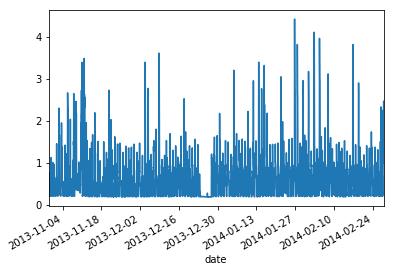

In [63]:
df[df['id'] == 'MAC000002']['energy'].plot()

Now, splite train and test.

In [71]:
df_train = df[df.index <= date_train]
df_test = df[df.index > date_train]

## Prepare Data for LSTM

In the next steps we have to generate the 3 dimensional arrays ([samples, n_in, n_features]) that we need for the LSTM. But before we do this, we have to normalize data.

In [ ]:
scaler = {}
df_train = df_train.groupby('id')

for name, group in groups:
  scr = MinMaxScaler()
  scr.fit(group[[h_params['column_value']]])
  scaler.update({name: scr})
  group[[h_params['column_value']]] = scr.transform(group[[h_params['column_value']]])

/home/simon/anaconda3/envs/r-tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/simon/anaconda3/envs/r-tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
group 

In [83]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train[[h_params['column_value']]] = scaler.fit_transform(df_train[[h_params['column_value']]])

/home/simon/anaconda3/envs/r-tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/simon/anaconda3/envs/r-tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [84]:
df_train.head()

,id,energy
date,,
2013-10-30 00:00:00+01:00,MAC000002,0.021899
2013-10-30 01:00:00+01:00,MAC000002,0.019838
2013-10-30 02:00:00+01:00,MAC000002,0.019551
2013-10-30 03:00:00+01:00,MAC000002,0.016867
2013-10-30 04:00:00+01:00,MAC000002,0.011979


### Define & Train LSTM Network

Let us try a simple 3 layer LSTM network.  

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(n_out))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=250, batch_size=32, validation_split = .2, verbose=2, shuffle=True)

Summarise the training and validation loss.

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()